# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [28]:
import gym
import numpy as np

In [29]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [30]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [31]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.02042426 -0.20316485 -0.0147583   0.27514407] 0 1.0 False {}
state, action, reward, done, info: [-0.02448755 -0.00783548 -0.00925542 -0.02215686] 1 1.0 False {}
state, action, reward, done, info: [-0.02464426 -0.20282348 -0.00969855  0.26759156] 0 1.0 False {}
state, action, reward, done, info: [-0.02870073 -0.00756447 -0.00434672 -0.02813451] 1 1.0 False {}
state, action, reward, done, info: [-0.02885202 -0.20262382 -0.00490941  0.26317381] 0 1.0 False {}
state, action, reward, done, info: [-3.29044984e-02 -3.97675348e-01  3.54063271e-04  5.54304222e-01] 0 1.0 False {}
state, action, reward, done, info: [-0.04085801 -0.59280227  0.01144015  0.84709868] 0 1.0 False {}
state, action, reward, done, info: [-0.05271405 -0.7880784   0.02838212  1.14335703] 0 1.0 False {}
state, action, reward, done, info: [-0.06847562 -0.98355946  0.05124926  1.44480375] 0 1.0 False {}
state, action, reward, done, info: [-0.08814681 -1.17927321  0.08014534  1.75304962]

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [32]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [33]:
# Data of the model
def model_input(state_size):
    # Calculating Qs
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    
    # Calculated targetQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return actions, states, rewards, targetQs

In [34]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [35]:
# Discriminator: Discriminting/differentiating between real and fake/generated actions
def discriminator(actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [60]:
def model_loss(actions, states, rewards, # Calculating Qs
               targetQs, # targetQs/nextQs
               action_size, hidden_size): # model init for Qs
        
    # # Calculate targetQs/nextQs
    # q_logits_fake = sess.run(model.q_logits_fake, feed_dict={model.states: states})            
    # rewarded_q_logits = np.multiply(q_logits_fake, np.reshape(rewards, [-1, 1]))
    # Qs = np.max(rewarded_q_logits, axis=1)
                
    # calculate Qs_fake
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    q_logits_fake = discriminator(actions=actions_logits, hidden_size=hidden_size)
    rewarded_q_logits_fake = tf.multiply(q_logits_fake, tf.reshape(rewards, shape=[-1, 1]))
    Qs_fake = tf.reduce_max(rewarded_q_logits_fake, axis=1)
    
    # calculate Qs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    q_logits_real = discriminator(actions=actions_onehot, hidden_size=hidden_size, reuse=True)
    rewarded_q_logits_real = tf.multiply(q_logits_real, tf.reshape(rewards, shape=[-1, 1]))
    Qs_real = tf.reduce_max(rewarded_q_logits_real, axis=1)
    
    # Calculating the g_loss and d_loss
    # g_loss = tf.reduce_mean(tf.square(Qs_fake[:-1] - targetQs[1:]))
    # d_loss = tf.reduce_mean(tf.square(Qs_real[:-1] - targetQs[1:]))
    # g_loss += tf.reduce_mean(tf.square(Qs_real[:-1]))
    # d_loss += tf.reduce_mean(tf.square(Qs_fake[:-1]))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_fake[:-1], 
                                                                    labels=tf.nn.sigmoid(targetQs[1:])))
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_real[:-1], 
                                                                    labels=tf.nn.sigmoid(targetQs[1:])))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_real[:-1], 
                                                                    labels=tf.zeros_like(targetQs[1:])))
    d_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_fake[:-1], 
                                                                    labels=tf.zeros_like(targetQs[1:])))
    
    return actions_logits, q_logits_fake, g_loss, d_loss

In [61]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for real and fake action discrimination
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [62]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.rewards, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_logits_fake, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            rewards=self.rewards, states=self.states, actions=self.actions, # Calculating Qs 
            targetQs=self.targetQs) # alculating targetQs/nextQs

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [63]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [64]:
print('state size:{}'.format(state.shape), 
      'action:{}'.format(action)) #(np.max(action) - np.min(action)+1)

state size:(4,) action:0


In [65]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [66]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [67]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    
    # Take one random step to get the pole and cart moving
    action = env.action_space.sample()
    state, _, done, _ = env.step(action)
    reward = 1 - float(done)
    memory.buffer.append((action, state, reward))
    
    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [68]:
state, reward, action

(array([-0.00376811, -0.62016818, -0.01743609,  0.88106479]), 1.0, 0)

In [69]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting after training session/graph
rewards_list = [] # accuracy
g_loss_list = [] # generator loss
d_loss_list = [] # discriminator loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        g_loss_batch = []
        d_loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            last_action_logits = actions_logits[-1]
            
            # Explore (Env) or Exploit (Model)
            # Take new action, get new state and reward
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # Cumulative rewards
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            q_logits_fake = sess.run(model.q_logits_fake, feed_dict={model.states: states})            
            rewarded_q_logits = np.multiply(q_logits_fake, np.reshape(rewards, [-1, 1]))
            Qs = np.max(rewarded_q_logits, axis=1)
    
            # Updating the model using NEW memory and targetQs/nextQs
            feed_dict = {model.actions: actions,
                         model.states: states, 
                         model.rewards: rewards, 
                         model.targetQs: Qs} # labelQs
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)

            # For average loss in one episode/epoch
            g_loss_batch.append(g_loss)
            d_loss_batch.append(d_loss)

            # At the end of steps/batches loop
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('-------------------------------------------------------------------------------')
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average g_loss: {:.4f}'.format(np.mean(g_loss_batch)),
              'Average d_loss: {:.4f}'.format(np.mean(d_loss_batch)),
              'Explore P: {:.4f}'.format(explore_p))
        print('-------------------------------------------------------------------------------')

        # At the end of each episode/epoch
        # total rewards and losses for plotting
        rewards_list.append((ep, total_reward))
        g_loss_list.append((ep, np.mean(g_loss_batch)))
        d_loss_list.append((ep, np.mean(d_loss_batch)))
        
    # At the end of all training episodes/epochs
    # Save the trained model
    saver.save(sess, 'checkpoints/model2.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 9.0 Average g_loss: 1.3505 Average d_loss: 1.3490 Explore P: 0.9990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19.0 Average g_loss: 1.1446 Average d_loss: 1.1921 Explore P: 0.9970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 22.0 Average g_loss: 0.7925 Average d_loss: 0.7855 Explore P: 0.9948
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 10.0 Average g_loss: 0.4139 Average d_loss: 0.4279 Explore P: 0.9937
-----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 18.0 Average g_loss: 0.2774 Average d_loss: 0.2678 Explore P: 0.9319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 16.0 Average g_loss: 0.2729 Average d_loss: 0.2608 Explore P: 0.9303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 8.0 Average g_loss: 0.2799 Average d_loss: 0.2688 Explore P: 0.9295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 9.0 Average g_loss: 0.2940 Average d_loss: 0.2823 Explore P: 0.9286
--------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 16.0 Average g_loss: 0.2579 Average d_loss: 0.2460 Explore P: 0.8702
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 8.0 Average g_loss: 0.2613 Average d_loss: 0.2481 Explore P: 0.8695
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 28.0 Average g_loss: 0.2584 Average d_loss: 0.2447 Explore P: 0.8670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 51.0 Average g_loss: 0.2415 Average d_loss: 0.2313 Explore P: 0.8625
-------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 14.0 Average g_loss: 0.2816 Average d_loss: 0.2689 Explore P: 0.8152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 24.0 Average g_loss: 0.2702 Average d_loss: 0.2584 Explore P: 0.8132
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 16.0 Average g_loss: 0.2762 Average d_loss: 0.2626 Explore P: 0.8118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 9.0 Average g_loss: 0.2834 Average d_loss: 0.2688 Explore P: 0.8110
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 133 Total reward: 16.0 Average g_loss: 0.2727 Average d_loss: 0.2588 Explore P: 0.7615
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 16.0 Average g_loss: 0.2844 Average d_loss: 0.2754 Explore P: 0.7602
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 40.0 Average g_loss: 0.2677 Average d_loss: 0.2590 Explore P: 0.7572
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 136 Total reward: 38.0 Average g_loss: 0.2565 Average d_loss: 0.2472 Explore P: 0.7543
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 42.0 Average g_loss: 0.2712 Average d_loss: 0.2627 Explore P: 0.7088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 22.0 Average g_loss: 0.2569 Average d_loss: 0.2454 Explore P: 0.7072
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 15.0 Average g_loss: 0.2635 Average d_loss: 0.2499 Explore P: 0.7060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 34.0 Average g_loss: 0.2614 Average d_loss: 0.2473 Explore P: 0.7036
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 23.0 Average g_loss: 0.3271 Average d_loss: 0.3066 Explore P: 0.6725
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 9.0 Average g_loss: 0.3292 Average d_loss: 0.3114 Explore P: 0.6718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 12.0 Average g_loss: 0.3312 Average d_loss: 0.3119 Explore P: 0.6710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 11.0 Average g_loss: 0.3413 Average d_loss: 0.3220 Explore P: 0.6702
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 232 Total reward: 27.0 Average g_loss: 0.3490 Average d_loss: 0.3428 Explore P: 0.6393
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 7.0 Average g_loss: 0.3433 Average d_loss: 0.3350 Explore P: 0.6388
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 12.0 Average g_loss: 0.3441 Average d_loss: 0.3416 Explore P: 0.6380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 10.0 Average g_loss: 0.3421 Average d_loss: 0.3357 Explore P: 0.6373
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 266 Total reward: 13.0 Average g_loss: 0.3736 Average d_loss: 0.3659 Explore P: 0.6108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 19.0 Average g_loss: 0.3747 Average d_loss: 0.3652 Explore P: 0.6096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 10.0 Average g_loss: 0.3736 Average d_loss: 0.3617 Explore P: 0.6090
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 14.0 Average g_loss: 0.3786 Average d_loss: 0.3743 Explore P: 0.6081
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 299 Total reward: 15.0 Average g_loss: 0.3488 Average d_loss: 0.3424 Explore P: 0.5810
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 12.0 Average g_loss: 0.3498 Average d_loss: 0.3410 Explore P: 0.5802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 10.0 Average g_loss: 0.3484 Average d_loss: 0.3407 Explore P: 0.5796
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 9.0 Average g_loss: 0.3531 Average d_loss: 0.3454 Explore P: 0.5790
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 333 Total reward: 12.0 Average g_loss: 0.3546 Average d_loss: 0.3390 Explore P: 0.5535
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 11.0 Average g_loss: 0.3649 Average d_loss: 0.3557 Explore P: 0.5529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 10.0 Average g_loss: 0.3705 Average d_loss: 0.3614 Explore P: 0.5523
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 336 Total reward: 9.0 Average g_loss: 0.3629 Average d_loss: 0.3498 Explore P: 0.5518
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 367 Total reward: 14.0 Average g_loss: 0.3829 Average d_loss: 0.3635 Explore P: 0.5292
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 9.0 Average g_loss: 0.3838 Average d_loss: 0.3693 Explore P: 0.5286
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 13.0 Average g_loss: 0.3810 Average d_loss: 0.3681 Explore P: 0.5279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 12.0 Average g_loss: 0.3773 Average d_loss: 0.3581 Explore P: 0.5272
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 400 Total reward: 8.0 Average g_loss: 0.3778 Average d_loss: 0.3651 Explore P: 0.5063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 20.0 Average g_loss: 0.3767 Average d_loss: 0.3665 Explore P: 0.5052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 11.0 Average g_loss: 0.3691 Average d_loss: 0.3535 Explore P: 0.5046
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 10.0 Average g_loss: 0.3743 Average d_loss: 0.3633 Explore P: 0.5041
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 434 Total reward: 13.0 Average g_loss: 0.3646 Average d_loss: 0.3514 Explore P: 0.4825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 13.0 Average g_loss: 0.3587 Average d_loss: 0.3417 Explore P: 0.4818
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 13.0 Average g_loss: 0.3609 Average d_loss: 0.3422 Explore P: 0.4812
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 437 Total reward: 11.0 Average g_loss: 0.3607 Average d_loss: 0.3436 Explore P: 0.4806
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 467 Total reward: 14.0 Average g_loss: 0.3768 Average d_loss: 0.3588 Explore P: 0.4624
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 11.0 Average g_loss: 0.3779 Average d_loss: 0.3590 Explore P: 0.4619
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 11.0 Average g_loss: 0.3760 Average d_loss: 0.3534 Explore P: 0.4613
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 470 Total reward: 16.0 Average g_loss: 0.3844 Average d_loss: 0.3665 Explore P: 0.4606
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 500 Total reward: 10.0 Average g_loss: 0.4116 Average d_loss: 0.4043 Explore P: 0.4440
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 10.0 Average g_loss: 0.4126 Average d_loss: 0.4066 Explore P: 0.4435
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 17.0 Average g_loss: 0.4087 Average d_loss: 0.4014 Explore P: 0.4428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 503 Total reward: 10.0 Average g_loss: 0.4047 Average d_loss: 0.3935 Explore P: 0.4423
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 533 Total reward: 14.0 Average g_loss: 0.4056 Average d_loss: 0.4001 Explore P: 0.4263
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 10.0 Average g_loss: 0.4035 Average d_loss: 0.3959 Explore P: 0.4259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 13.0 Average g_loss: 0.4076 Average d_loss: 0.4034 Explore P: 0.4253
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 536 Total reward: 13.0 Average g_loss: 0.4061 Average d_loss: 0.3985 Explore P: 0.4247
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 567 Total reward: 11.0 Average g_loss: 0.4276 Average d_loss: 0.4202 Explore P: 0.4105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 10.0 Average g_loss: 0.4300 Average d_loss: 0.4251 Explore P: 0.4101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 13.0 Average g_loss: 0.4396 Average d_loss: 0.4371 Explore P: 0.4095
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 570 Total reward: 11.0 Average g_loss: 0.4380 Average d_loss: 0.4307 Explore P: 0.4091
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 600 Total reward: 9.0 Average g_loss: 0.4109 Average d_loss: 0.3951 Explore P: 0.3946
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 16.0 Average g_loss: 0.4109 Average d_loss: 0.3983 Explore P: 0.3940
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 17.0 Average g_loss: 0.4037 Average d_loss: 0.3898 Explore P: 0.3933
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 10.0 Average g_loss: 0.4045 Average d_loss: 0.3907 Explore P: 0.3929
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 633 Total reward: 9.0 Average g_loss: 0.3998 Average d_loss: 0.3916 Explore P: 0.3783
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 10.0 Average g_loss: 0.4014 Average d_loss: 0.3928 Explore P: 0.3779
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 11.0 Average g_loss: 0.3985 Average d_loss: 0.3890 Explore P: 0.3775
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 636 Total reward: 11.0 Average g_loss: 0.4005 Average d_loss: 0.3920 Explore P: 0.3770
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 667 Total reward: 9.0 Average g_loss: 0.4316 Average d_loss: 0.4265 Explore P: 0.3640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 10.0 Average g_loss: 0.4346 Average d_loss: 0.4316 Explore P: 0.3636
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 12.0 Average g_loss: 0.4294 Average d_loss: 0.4229 Explore P: 0.3632
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 9.0 Average g_loss: 0.4357 Average d_loss: 0.4308 Explore P: 0.3628
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 700 Total reward: 16.0 Average g_loss: 0.4430 Average d_loss: 0.4392 Explore P: 0.3508
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 11.0 Average g_loss: 0.4369 Average d_loss: 0.4264 Explore P: 0.3504
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 10.0 Average g_loss: 0.4367 Average d_loss: 0.4270 Explore P: 0.3500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 10.0 Average g_loss: 0.4383 Average d_loss: 0.4333 Explore P: 0.3496
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 733 Total reward: 12.0 Average g_loss: 0.4389 Average d_loss: 0.4298 Explore P: 0.3384
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 10.0 Average g_loss: 0.4419 Average d_loss: 0.4312 Explore P: 0.3380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 9.0 Average g_loss: 0.4433 Average d_loss: 0.4382 Explore P: 0.3377
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 9.0 Average g_loss: 0.4450 Average d_loss: 0.4413 Explore P: 0.3373
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 766 Total reward: 11.0 Average g_loss: 0.4362 Average d_loss: 0.4263 Explore P: 0.3264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 14.0 Average g_loss: 0.4342 Average d_loss: 0.4217 Explore P: 0.3260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 9.0 Average g_loss: 0.4345 Average d_loss: 0.4253 Explore P: 0.3256
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 7.0 Average g_loss: 0.4380 Average d_loss: 0.4307 Explore P: 0.3254
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 800 Total reward: 10.0 Average g_loss: 0.4298 Average d_loss: 0.4210 Explore P: 0.3141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 8.0 Average g_loss: 0.4321 Average d_loss: 0.4224 Explore P: 0.3139
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 802 Total reward: 11.0 Average g_loss: 0.4253 Average d_loss: 0.4084 Explore P: 0.3135
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 803 Total reward: 8.0 Average g_loss: 0.4281 Average d_loss: 0.4118 Explore P: 0.3132
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 833 Total reward: 9.0 Average g_loss: 0.4474 Average d_loss: 0.4437 Explore P: 0.3032
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 19.0 Average g_loss: 0.4414 Average d_loss: 0.4327 Explore P: 0.3026
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 9.0 Average g_loss: 0.4397 Average d_loss: 0.4320 Explore P: 0.3023
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 9.0 Average g_loss: 0.4422 Average d_loss: 0.4378 Explore P: 0.3020
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 866 Total reward: 11.0 Average g_loss: 0.4453 Average d_loss: 0.4363 Explore P: 0.2926
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 14.0 Average g_loss: 0.4466 Average d_loss: 0.4417 Explore P: 0.2922
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 10.0 Average g_loss: 0.4498 Average d_loss: 0.4496 Explore P: 0.2919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 11.0 Average g_loss: 0.4452 Average d_loss: 0.4396 Explore P: 0.2915
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 900 Total reward: 8.0 Average g_loss: 0.4523 Average d_loss: 0.4455 Explore P: 0.2825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 15.0 Average g_loss: 0.4571 Average d_loss: 0.4536 Explore P: 0.2821
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 17.0 Average g_loss: 0.4467 Average d_loss: 0.4367 Explore P: 0.2816
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 10.0 Average g_loss: 0.4472 Average d_loss: 0.4410 Explore P: 0.2813
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 934 Total reward: 8.0 Average g_loss: 0.4476 Average d_loss: 0.4336 Explore P: 0.2720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 935 Total reward: 8.0 Average g_loss: 0.4491 Average d_loss: 0.4345 Explore P: 0.2718
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 8.0 Average g_loss: 0.4525 Average d_loss: 0.4395 Explore P: 0.2716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 7.0 Average g_loss: 0.4582 Average d_loss: 0.4488 Explore P: 0.2714
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 967 Total reward: 10.0 Average g_loss: 0.4747 Average d_loss: 0.4745 Explore P: 0.2631
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 968 Total reward: 8.0 Average g_loss: 0.4703 Average d_loss: 0.4630 Explore P: 0.2629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 8.0 Average g_loss: 0.4721 Average d_loss: 0.4610 Explore P: 0.2626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 10.0 Average g_loss: 0.4729 Average d_loss: 0.4678 Explore P: 0.2624
----------------------------------------------------------

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

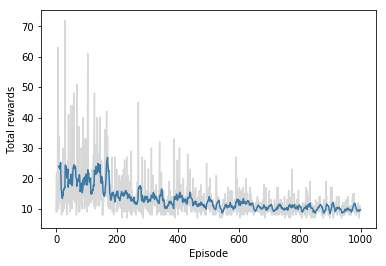

In [75]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average g_losses')

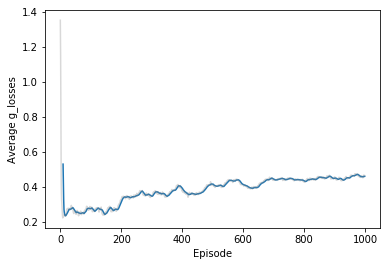

In [76]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average g_losses')

Text(0,0.5,'Average d_losses')

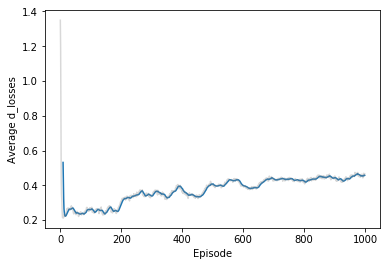

In [77]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average d_losses')

## Testing

Let's checkout how our trained agent plays the game.

In [25]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

with tf.Session() as sess:

    # Initialize/restore/load the trained model 
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):

        # Start a new episode/epoch
        env.reset()
        
        # number of env/rob steps
        for _ in range(test_max_steps):
            
            # Rendering the env graphics
            env.render()
            
            # Batch from the OLD memory
            batch = memory.buffer
            #actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            
            # Calculating next action using OLD memory
            feed_dict={model.states: states}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            last_action_logits = actions_logits[-1]
            
            # Take action, get new state and reward
            #action = env.action_space.sample()
            action = np.argmax(last_action_logits)
            state, _, done, _ = env.step(action)
            reward = 1 - float(done)
            
            # New memory (time direction)
            memory.buffer.append((action, state, reward))
            
            # The task is done or not;
            if done:
                break
                
# Closing the env
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.